# Plot Figure 1

The code in this notebook was executed using both R and python kernels, and includes:

* Plotting of the UMAP in Figure 1c
* Calculation and plotting of upregulated genes for Figure 1D
* Plotting of Figure 1F
* Plotting of Figure 1G

<br>

## Figure 1c UMAP

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import scanpy as sc

from collections import Counter

data_path = "/lustre/scratch126/casm/team274sb/hw12/T_ALL/data/GEOSubmission/cellXgene/OriginalCohort.h5ad"
save_dir = "/lustre/scratch126/casm/team274sb/hw12/T_ALL/data/"

In [2]:
## -- Load data
adata = sc.read_h5ad(data_path)

In [3]:
## -- Get extra metadata
manifest = pd.read_csv("/lustre/scratch126/casm/team274sb/bl10/T-ALL/Data/TALL_manifest_NEW.csv")
manifest = manifest[manifest['Experiment'] == "GEX"]
manifest = manifest[manifest['Omit'] == "No"]
manifest = manifest.sort_values(by = ['Sample_ID'], ignore_index = True)

mapping_dict = dict(zip(manifest['Sample_ID'], manifest['Timepoint']))
adata.obs['timepoint'] = adata.obs['sample_ID'].map(mapping_dict)

response_dict = dict(zip(manifest["Sample_ID"].tolist(),manifest["Response"].tolist()))
adata.obs['Response'] = [response_dict[i] for i in adata.obs['sample_ID'].tolist()]

adata.obs['PlotGroup'] = adata.obs['timepoint']+adata.obs['Response']

In [6]:
adata.obs['final_anno'] =  [i.split("_")[0] if "Leuk" in i else i.split("_")[1] for i in adata.obs['PlotGroup'].astype(str) + "_" + adata.obs['broad_anno'].astype(str)]

### Plot


/home/jovyan/my-conda-envs/scPy_3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/scPy_3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/scPy_3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/scPy_3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/scPy_3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

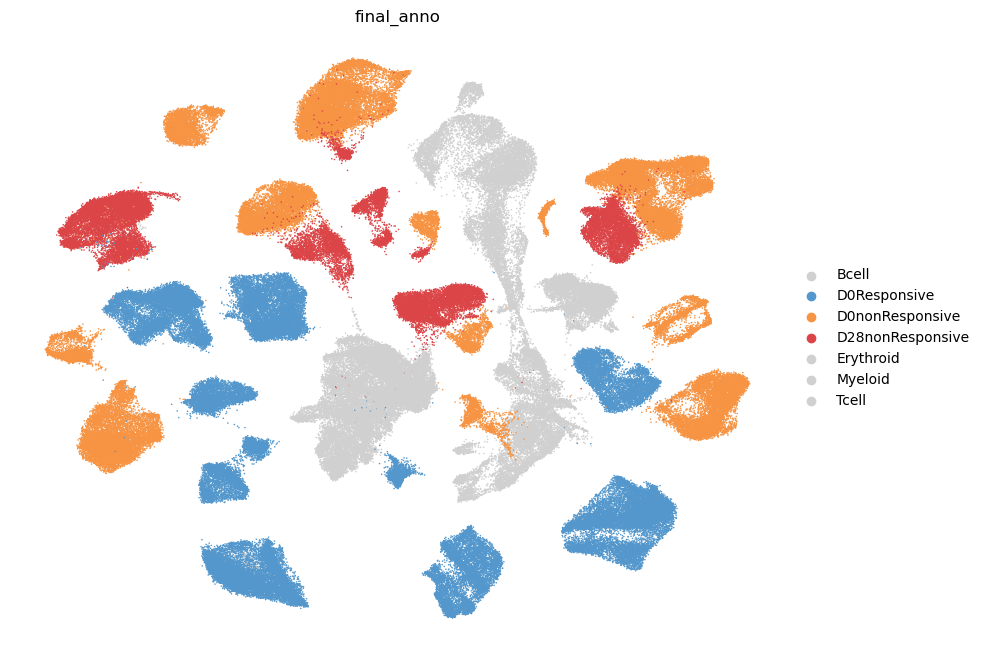

In [12]:
final_anno_colours_3Leuk = {'D0nonResponsive': "#F69443",
         'Tcell': "#D0D0D0",
         'Myeloid': "#D0D0D0",
         'Erythroid': "#D0D0D0",
         'D28nonResponsive': "#DB4548",
         'Bcell': "#D0D0D0",
         'Others': "#D0D0D0",
         'D0Responsive': "#5397CC"}


fig, ax = plt.subplots(figsize = (10, 8))
sc.pl.umap(adata[~(adata.obs["final_anno"].isin(["Others", "Doublets"]))], #& (adata.obs["sample_ID"].isin(["P112_D0"])) 
           color = 'final_anno',sort_order=True,
           palette = final_anno_colours_3Leuk, legend_loc = 'right margin', 
           ax = ax, size=5, frameon=False )

<br>

## Figure 1D

### Calculate upregulated genes using scanpy in python

In [ ]:
## -- Subset to leuk
adata_x = adata[ (adata.obs["broad_anno"].isin(["Leuk"]))]

## -- Rank genes per sample_ID
adata_x.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata_x, groupby='sample_ID', method='wilcoxon',groups=["P058_D28", "P030_D28"],use_raw=False)

## -- Get genes up in D28
P058_D28_markers_df = sc.get.rank_genes_groups_df(adata_x, group="P058_D28")
P030_D28_markers_df = sc.get.rank_genes_groups_df(adata_x, group="P030_D28")

In [ ]:
## -- Get top genes and check for overlap
P030_genes = P030_D28_markers_df.sort_values(by = 'scores', ascending = False)["names"].tolist()[0:100]
P058_genes = P058_D28_markers_df.sort_values(by = 'scores', ascending = False)["names"].tolist()[0:100]
set(P058_genes).intersection(set(P030_genes))

In [ ]:
## -- Save for plotting in R
P058_D28_markers_df["Group"] = ["P058_D28"]*P058_D28_markers_df.shape[0]
P030_D28_markers_df["Group"] = ["P030_D28"]*P030_D28_markers_df.shape[0]

path_to_save = "/lustre/scratch126/casm/team274sb/hw12/T_ALL/figures/paper_figures/figure_1/"
data_x = pd.concat([P058_D28_markers_df,P030_D28_markers_df])
data_x.to_csv(str(path_to_save)+"rank_genes_output.txt", sep="\t",header=True, index=False,)

### Plot in R

Change kernel to R

In [1]:
requiredPackages <- c("ggplot2", "gtable", "stringr", "grid") #"Manu",

for (pkg in requiredPackages){
  suppressWarnings(suppressMessages(library(pkg, character.only = T)))
}

path_to_save = "/lustre/scratch126/casm/team274sb/hw12/T_ALL/figures/paper_figures/figure_1/"

overlapping_genes = c('FKBP5', 'GLUL', 'TSC22D3', 'TXNIP', 'ZBTB16', 'ZFP36L2', 'RNF130', 'KLF13')



In [2]:
THEME <- theme(panel.grid.minor = element_blank(),
                 panel.grid.major = element_blank(),
                 axis.text.y = element_blank(),
                 axis.text.x = element_text(size=12),
                 axis.title.y = element_blank(),
                 axis.title.x = element_text(size=14),
                # axis.ticks.y=element_blank(),
                 axis.ticks.length.y = unit(0.0001, "pt"),
                 axis.ticks.x.bottom = element_line(colour="black"),
                 axis.ticks.length.x = unit(0.5, "pt"),
                 axis.line.x = element_line(colour = "black"),
                 plot.title = element_text(size = 16, hjust = 0.5))

col_dict = setNames(c("#D72E29","grey"),c("Y", "N"))

In [3]:
## -- Prep data
data_x = read.table(file=paste0(path_to_save,"rank_genes_output.txt"), sep="\t", header=TRUE)
data_x$Genes <- data_x$names
data_x$logFC <- data_x$logfoldchanges
data_x$Statistic <- data_x$scores
data_x$Highlight <- ifelse(data_x$names %in% c("ZBTB16"), "Y", "N")

data_x = data_x[data_x$Group %in% c("P058_D28","P030_D28"),]
data_x = data_x[data_x$names %in% overlapping_genes,]

data_A = data_x[data_x$Group %in% c("P058_D28"),]
data_B = data_x[data_x$Group %in% c("P030_D28"),]

## -- For plot
gene_order = data_A[rev(order(data_A$logfoldchanges)),]$name
ymax <- ceiling(max(c(abs(data_A$logFC), abs(data_B$logFC))))

### 1. Plot RHS

In [4]:
data_B$Genes <- factor(data_B$Genes, levels = rev(gene_order))

gg_Y <- ggplot(data = data_B, aes(x=Genes)) +
    geom_bar(aes(y = logFC, fill=Highlight), stat = "identity") + #theme_bw() +
    coord_flip() + scale_y_continuous(breaks=seq(0,ymax,1), labels=seq(0,ymax,1),  limits = c(0, ymax), expand = c(0,0)) +
    labs(x = NULL)+ggtitle("P030 (D28)")+THEME+ theme(plot.margin= unit(c(1, 0, 0, 0), "lines"))+
scale_fill_manual("", values = col_dict)+scale_alpha(range = c(0.1, 1), guide='legend')+
theme(panel.border = element_blank())

## -- Get ggplot grob
gg_Y_grob <- ggplotGrob(gg_Y)

## -- Get legend
leg = gg_Y_grob$grobs[[which(gg_Y_grob$layout$name == "guide-box")]]

## -- Remove legend
legPos = gg_Y_grob$layout$l[grepl("guide", gg_Y_grob$layout$name)]  # legend's position
  gg_Y_grob = gg_Y_grob[, -c(legPos-1,legPos)]

### 2. Plot LHS

In [5]:
data_A$Genes <- factor(data_A$Genes, levels = rev(gene_order))
gg_X <- ggplot(data =data_A, aes(x=Genes)) +
    geom_bar(aes(y = logFC, fill=Highlight), stat = "identity") + # , alpha=Statistic , alpha="Scanpy Score" theme_bw() +
    coord_flip() + scale_y_continuous(breaks=seq(0,ymax,1), labels=seq(0,ymax,1), trans = 'reverse', limits = c(ymax, 0), expand = c(0,0)) + THEME+
    labs(x = NULL)+ggtitle("P058 (D28)")+ theme(plot.margin= unit(c(1, 0, 0, 1), "lines"))+
        scale_fill_manual("Direction", values = col_dict)+scale_alpha(range = c(0.1, 1), guide='legend')+
            theme(panel.border = element_blank())

## -- Get ggplot grob
gg_X_grob <- ggplotGrob(gg_X)

## -- Get legend
leg = gg_X_grob$grobs[[which(gg_X_grob$layout$name == "guide-box")]]

## -- Remove legend
gg_X_grob = gg_X_grob[, -c(legPos-1,legPos)]

## -- Swap the tick marks to the right side of the plot panel
# Get the row number of the left axis in the layout
rn <- which(gg_X_grob$layout$name == "axis-l")

## -- Extract the axis (tick marks and axis text)
axis.grob <- gg_X_grob$grobs[[rn]]
axisl <- axis.grob$children[[2]]  # Two children - get the second
# axisl  # Note: two grobs -  text and tick marks

## -- Get the tick marks - NOTE: tick marks are second
yaxis = axisl$grobs[[2]]
yaxis$x = yaxis$x - unit(1, "npc") + unit(2.75, "pt") # Reverse them

## -- Add them to the right side of the panel
# Add a column to the gtable
panelPos = gg_X_grob$layout[grepl("panel", gg_X_grob$layout$name), c('t','l')]
gg_X_grob <- gtable_add_cols(gg_X_grob, gg_X_grob$widths[3], panelPos$l)

## -- Add the grob
gg_X_grob <-  gtable_add_grob(gg_X_grob, yaxis, t = panelPos$t, l = panelPos$l+1)

## -- Remove original left axis
gg_X_grob = gg_X_grob[, -c(2,3)]

### 3. Gene labels

In [6]:
## -- Create a plot using geom_text - to appear down the middle
fontsize = 5
gg_LABELS <- ggplot(data = data_B, aes(x=Genes)) +
    geom_bar(stat = "identity", aes(y = 0)) +
    geom_text(aes(y = 0,  label = Genes), size = fontsize) +
    ggtitle("Genes") +
    coord_flip() + theme_bw() + THEME+
    theme(panel.border = element_rect(colour = NA))

## -- Get ggplot grob
gg_LABELS <- ggplotGrob(gg_LABELS)

## -- Get the title
Title = gg_LABELS$grobs[[which(gg_LABELS$layout$name == "title")]]

## -- Get the plot panel
gg_LABELS = gg_LABELS$grobs[[which(gg_LABELS$layout$name == "panel")]]

## --  Arrange the components
## First, combine "LEFT" and "RIGHT" plots
gg_final = cbind(gg_X_grob, gg_Y_grob, size = "first")

## -- Second, add the labels (gtC) down the middle
# add column to gtable
maxlab = gene_order[which(str_length(gene_order) == max(str_length(gene_order)))]
gg_final = gtable_add_cols(gg_final, sum(unit(1, "grobwidth", textGrob(maxlab, gp = gpar(fontsize = fontsize*72.27/25.4))), unit(5, "mm")),
                             pos = length(gg_X_grob$widths))

## --  add the grob
gg_final = gtable_add_grob(gg_final, gg_LABELS, t = panelPos$t, l = length(gg_X_grob$widths) + 1)

## --  add the title; ie the label 'country'
titlePos = gg_X_grob$layout$l[which(gg_X_grob$layout$name == "title")]
gg_final = gtable_add_grob(gg_final, Title, t = titlePos, l = length(gg_X_grob$widths) + 1)

## --  Third, add the legend to the right
gg_final = gtable_add_cols(gg_final, sum(leg$width), -1)
gg_final = gtable_add_grob(gg_final, leg, t = panelPos$t, l = length(gg_final$widths))

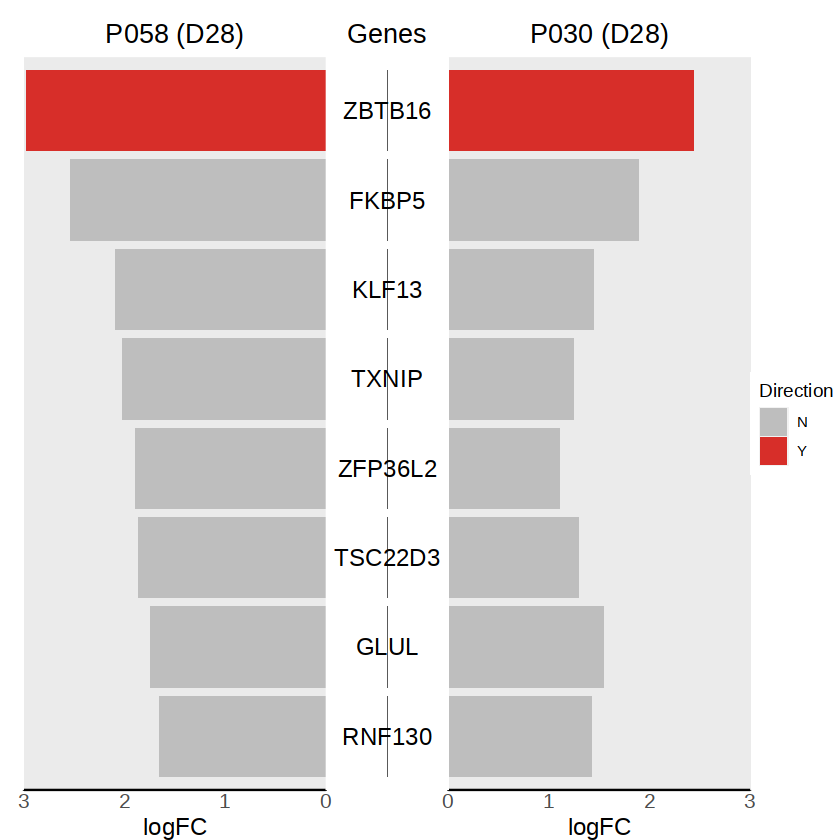

In [7]:
grid.newpage()
grid.draw(gg_final)

<br>

## Plotting Figure 1F


Code executed in R

In [17]:
requiredPackages <- c("ggplot2",  "tidyverse", "ggpubr","patchwork","ggrepel", "ggrastr", "ggbeeswarm") 

for (pkg in requiredPackages){
  suppressWarnings(suppressMessages(library(pkg, character.only = T)))
}



### Load and prep data

In [18]:
df = read.csv("/lustre/scratch126/casm/team274sb/project_folders/T_ALL_paper/11_Figure_1/Data/TALL_leuk_gene_expression.csv", check.names = FALSE)


In [19]:
df = df %>% 
  mutate(sample_cluster = paste0(sample_ID, "::", leiden)) %>%
  mutate(timepoint_response = paste0(timepoint, "_", response))

df$timepoint_response = factor(df$timepoint_response, levels = c("D0_Responsive", "D0_nonResponsive", "D28_nonResponsive"))

sample_cluster_TABLE = df %>% count(sample_cluster)
match_index = match(x = df$sample_cluster, table = sample_cluster_TABLE$sample_cluster)
df$sample_cluster_COUNT = sample_cluster_TABLE$n[match_index]

sample_ID_TABLE = df %>% count(sample_ID)
match_index = match(x = df$sample_ID, table = sample_ID_TABLE$sample_ID)
df$sample_ID_COUNT = sample_ID_TABLE$n[match_index]

df$sample_cluster_FRACT = df$sample_cluster_COUNT / df$sample_ID_COUNT

In [20]:
df_sample = df %>%
  group_by(sample_ID) %>%
  mutate(exp = median(.data[["ZBTB16"]])) %>%
  mutate(mean = mean(.data[["ZBTB16"]])) %>% 
  ungroup() %>% 
  distinct(sample_ID, .keep_all = TRUE) %>%
  arrange(exp, mean)

df_cluster = df %>%
  group_by(sample_cluster) %>%
  mutate(exp = median(.data[["ZBTB16"]])) %>% 
  ungroup() %>% 
  distinct(sample_cluster, .keep_all = TRUE)

df_binary = df[c("sample_ID", "timepoint_response", "ZBTB16")] %>%
  mutate(is_positive = .data[["ZBTB16"]] > 0)

df_sample$sample_ID = factor(df_sample$sample_ID, levels = df_sample$sample_ID)
df$sample_ID = factor(df$sample_ID, levels = df_sample$sample_ID)
df_cluster$sample_ID = factor(df_cluster$sample_ID, levels = df_sample$sample_ID)
df_binary$sample_ID = factor(df_binary$sample_ID, levels = df_sample$sample_ID)

### Plot

Warning message in geom_boxplot(alpha = 0, outliers = FALSE):
“Ignoring unknown parameters: `outliers`”


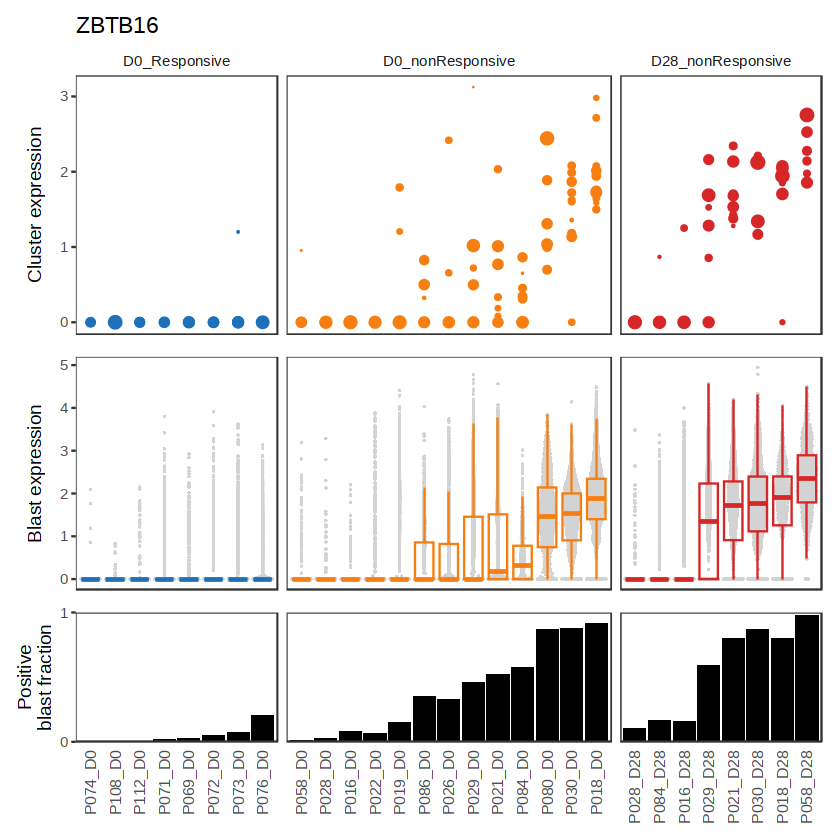

In [21]:
p1 = ggplot() + 
  geom_point(data = df_cluster, mapping = aes(x = sample_ID, y = exp, fill = timepoint_response, size = sample_cluster_FRACT), 
             stroke = NA, shape = 21, show.legend = FALSE) + 
  scale_size_area(max_size = 4) + 
  scale_fill_manual(values = c("D0_Responsive" = "#1D71B8", "D0_nonResponsive" = "#F77F11", "D28_nonResponsive" = "#D62728")) +
  facet_grid(cols = vars(timepoint_response), scales = "free_x", space = "free_x") + 
  ylab("Cluster expression") + 
  ggtitle("ZBTB16") + 
  theme_bw() + 
  theme(
    axis.text.x = element_blank()
  )

p2 = ggplot(data = df, mapping = aes(x = sample_ID, y = .data[["ZBTB16"]], col = timepoint_response)) +
  rasterise(geom_quasirandom(size = 0.2, col = "#D3D3D3", show.legend = FALSE), dpi = 1200) +
  geom_boxplot(alpha = 0, outliers = FALSE) +
  scale_colour_manual(values = c("D0_Responsive" = "#1D71B8", "D0_nonResponsive" = "#F77F11", "D28_nonResponsive" = "#D62728")) +
  facet_grid(cols = vars(timepoint_response), scales = "free_x", space = "free_x") +
  ylab("Blast expression") +
  theme_bw() +
  theme(
    strip.text.x = element_blank(), 
    axis.text.x = element_blank()
  )

p3 = ggplot(df_binary, aes(x = sample_ID, fill = is_positive)) + 
  geom_bar(position = "fill") + 
  scale_fill_manual(values = c("#FFFFFF", "#000000"), labels = c("Not expressed", "Expressed"), name = "") + 
  facet_grid(cols = vars(timepoint_response), scales = "free_x", space = "free_x") + 
  scale_y_continuous(breaks = c(0, 1), labels = c(0, 1), limits = c(0, 1), expand = c(0, 0)) +
  ylab("Positive\nblast fraction") + 
  theme_bw() +
  theme(
    strip.text.x = element_blank(), 
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 9)
  )

p = p1 + p2 + p3 + plot_layout(nrow = 3, ncol = 1, heights = c(2, 1.8, 1), guides = "collect") & 
  theme(
    strip.background = element_blank(),
    legend.position = "none",
    legend.title = element_blank(), 
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank(), 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )

p

<br>


## Figure 1G

Code executed in R

### Load data

In [23]:
df = read.csv("/lustre/scratch126/casm/team274sb/project_folders/T_ALL_paper/11_Figure_1/Data/TALL_leuk_gene_expression.csv", check.names = FALSE)


In [24]:
list_of_sample_ID = c('P058_D0', 'P058_D28', 'P028_D0', 'P028_D28', 'P016_D0', 'P016_D28', 'P029_D0', 'P029_D28', 'P021_D0', 'P021_D28', 'P084_D0', 'P084_D28', 'P030_D0', 'P030_D28', 'P018_D0', 'P018_D28')
df = df[df$sample_ID %in% list_of_sample_ID, ]

### Prep data

In [25]:
df_sample = df %>%
  group_by(sample_ID) %>%
  mutate(is_positive = .data[["ZBTB16"]] > 0) %>%
  mutate(positive_fract = mean(is_positive)) %>%
  filter(is_positive) %>%
  mutate(median_positive = median(.data[["ZBTB16"]])) %>%
  ungroup() %>% 
  distinct(sample_ID, .keep_all = TRUE)
df_sample$sample_ID = factor(df_sample$sample_ID, levels = list_of_sample_ID)
df_sample = df_sample %>% arrange(sample_ID)
df_sample = df_sample[c('sample_ID', 'timepoint', 'positive_fract', 'median_positive')]


In [26]:
p1 = ggplot(df_sample, aes(x = sample_ID, y = median_positive, fill = timepoint)) +
  geom_col() +
  scale_fill_manual(values = c("D0" = "#F77F11", "D28" = "#D62728")) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) +
  ylab("Median") +
  theme_bw() +
  theme(
    axis.text.x = element_blank()
  )

p2 = ggplot(df_sample, aes(x = sample_ID, y = positive_fract, fill = timepoint)) +
  geom_col() +
  scale_fill_manual(values = c("D0" = "#F77F11", "D28" = "#D62728")) +
  scale_y_continuous(breaks = c(0, 1), labels = c(0, 1), limits = c(0, 1), expand = c(0, 0)) +
  ylab("Fraction") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
  )

p = p1 + p2 + plot_layout(nrow = 2, ncol = 1, heights = c(1, 1), guides = "collect") & 
  theme(
    legend.position = "none", 
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank(), 
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank()
  )


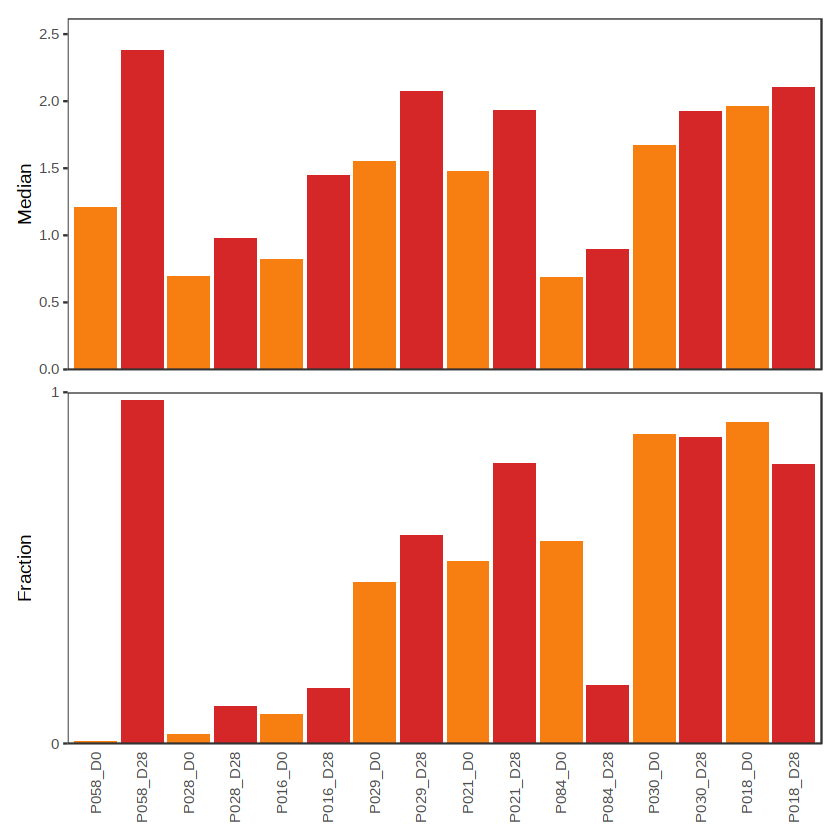

In [27]:
p